### Get label information

Validation and test data were combined and split evenly, as the given data sets for validation and testing were inherently skewed. There were 0 viral pneumonia images and only 17 images total in the given validation data set, while the testing data set had 234, 242, and 148 images for normal, bacterial, and viral cases.

To normalize different data set sizes, a random selection of the minimum number of images for a label type was selected. 

Before normalizing, the sizes of the datasets (normal, bacterial, viral) were:
* train - [1342, 2530, 1345]
* validate - [9, 8, 0]
* test - [234, 242, 148]

After normalizing:
* train - [1342, 1342, 1342]
* validate - [74, 74, 74]
* test - [74, 74, 74]

In [1]:
import tensorflow as tf
from tensorflow.keras.applications import Xception, InceptionV3
from tensorflow.keras.layers import GlobalAveragePooling2D
import tensorflow.contrib.eager as tfe
from matplotlib import pyplot as plt
import numpy as np
import pickle 

%matplotlib inline
tf.enable_eager_execution()

import csv
import os
import glob
import random

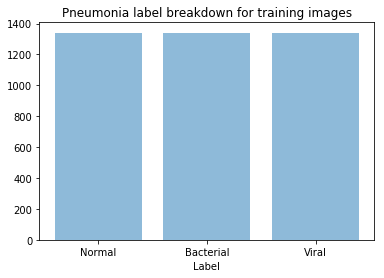

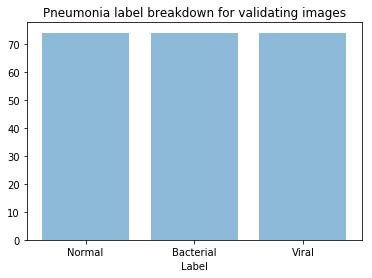

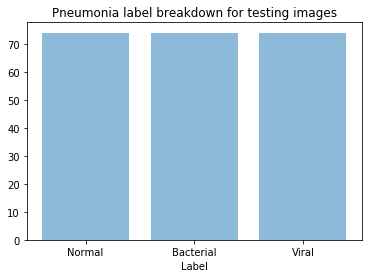

In [2]:
TRAIN_PATH = '/home/final/data/train'
VALIDATE_TEST_PATH = '/home/final/data/val_test'
# VALIDATE_PATH = '/home/final/data/val'
# TEST_PATH = '/home/final/data/test'
zipped_data = []

for i, ROOT_PATH in enumerate([TRAIN_PATH, VALIDATE_TEST_PATH]):

    NORMAL_PATH = os.path.join(ROOT_PATH, 'NORMAL')
    PNEUMONIA_PATH = os.path.join(ROOT_PATH, 'PNEUMONIA')
    EXT = '.jpeg'

    file_paths = []
    labels = ['normal', 'bacteria' ,'virus']

    normal_files = glob.glob(os.path.join(NORMAL_PATH, '*.jpeg'))
    bacteria_files = glob.glob(os.path.join(PNEUMONIA_PATH, '*bacteria*.jpeg'))
    virus_files = glob.glob(os.path.join(PNEUMONIA_PATH, '*virus*.jpeg'))
    random.shuffle(normal_files)
    random.shuffle(bacteria_files)
    random.shuffle(virus_files)
    
    n_norm = len(normal_files)
    n_bact = len(bacteria_files)
    n_viru = len(virus_files)

     # 
    if i == 0: 
        # if training data, normalize data set sizes to min of three labels
        minimum = min(n_norm, n_bact, n_viru)
        fps = normal_files[:minimum] + bacteria_files[:minimum] + virus_files[:minimum]
        labels = minimum * [0] + minimum * [1] + minimum * [2]
        zipped_data.append(list(zip(fps, labels)))
        
        objects = ('Normal', 'Bacterial', 'Viral')
        y_pos = np.arange(len(objects))
        performance = [minimum, minimum, minimum]

        plt.bar(y_pos, performance, align='center', alpha=0.5)
        plt.xticks(y_pos, objects)
        plt.xlabel('Label')
        plt.title('Pneumonia label breakdown for training images')
        plt.show()
        
    elif i == 1:
        # if validation or testing data, combine and split into two 
        minimum = int(min(n_norm, n_bact, n_viru)//2)
        fps_val = normal_files[:minimum] + bacteria_files[:minimum] + virus_files[:minimum]
        fps_tst = normal_files[(minimum+1):(2*minimum)] + bacteria_files[(minimum+1):(2*minimum)] + virus_files[(minimum+1):(2*minimum)]
        lbl_val = minimum * [0] + minimum * [1] + minimum * [2]
        lbl_tst = minimum * [0] + minimum * [1] + minimum * [2]
        
        zipped_data.append(list(zip(fps_val, lbl_val)))
        zipped_data.append(list(zip(fps_tst, lbl_tst)))
        
        objects = ('Normal', 'Bacterial', 'Viral')
        y_pos = np.arange(len(objects))
        performance = [minimum, minimum, minimum]

        plt.bar(y_pos, performance, align='center', alpha=0.5)
        plt.xticks(y_pos, objects)
        plt.xlabel('Label')
        plt.title('Pneumonia label breakdown for validating images')
        plt.show()
        plt.bar(y_pos, performance, align='center', alpha=0.5)
        plt.xticks(y_pos, objects)
        plt.xlabel('Label')
        plt.title('Pneumonia label breakdown for testing images')
        plt.show()
    

    

## Setting up dataset and saving bottlenecks

In [12]:
# class XceptionBottleneck(tf.keras.Model):    
class InceptionBottleneck(tf.keras.Model):
    def __init__(self):
        #super(XceptionBottleneck, self).__init__()
        super(InceptionBottleneck, self).__init__()
        # self.xception_layers = Xception(include_top=False, weights='imagenet')
        self.inception_layers = InceptionV3(include_top=False, weights='imagenet')
        self.pooling_layer = GlobalAveragePooling2D(data_format='channels_last')
    
    def call(self, inputs):
        # result = self.xception_layers(inputs)
        result = self.inception_layers(inputs)
        result = self.pooling_layer(result)
        return result
    
def cache_bottleneck_layers(paths, batch_size, device):
    dataset = create_dataset_fmr_images(paths).batch(batch_size)
    bottle_necks = []
    n_samples = len(file_paths)
    
    with tf.device(device):
        inception_out = InceptionBottleneck()
        for batch_num, image in enumerate(dataset):
            print('\rComputing bottle neck layers... batch {} of {}'.format(batch_num+1, n_samples//batch_size), end="")
            # Compute bottle necks layer for image batch convert to numpy and append to bottle_necks
            bottle_necks.append(np.array(inception_out(image)))

    return np.vstack(bottle_necks)

def create_dataset_fmr_images(file_paths):
    # Reads an image from a file, decodes it into a dense tensor, and resizes it
    # to a fixed shape. Read more here: https://www.tensorflow.org/guide/datasets#decoding_image_data_and_resizing_it
    def _parse_function(filename):
        
        # Create tensor from image and resize to 200 x 200
        image_string = tf.read_file(filename)
        image_decoded = tf.image.decode_jpeg(image_string)
        image_resized = tf.image.resize_images(image_decoded, [300, 300])
        image_tensor = tf.convert_to_tensor(image_resized)
        
        # Convert image to rgb if grayscale
        # https://stackoverflow.com/questions/54884305/tensorflow-convert-image-to-rgb-if-grayscale
        image_rgb = tf.cond(tf.equal(tf.shape(image_tensor)[2], 1),
                           lambda: tf.image.grayscale_to_rgb(image_tensor),
                           lambda: tf.identity(image_tensor))
        
        # Add shape information
        s = image_tensor.shape
        image_rgb.set_shape((300,300,3))

        return image_rgb
    
    def _generate_data(filename):
        # Create tensor from image and resize to 200 x 200
        image_string = tf.read_file(filename)
        image_decoded = tf.image.decode_jpeg(image_string)
        image_resized = tf.image.resize_images(image_decoded, [300, 300])
        image_augmented = tf.image.flip_left_right(image_resized)
        image_augmented = tf.image.random_brightness(image_augmented, max_delta=0.5)
        image_augmented = tf.contrib.image.rotate(image_augmented, angles=20)
        image_tensor = tf.convert_to_tensor(image_augmented)
        
        # Convert image to rgb if grayscale
        # https://stackoverflow.com/questions/54884305/tensorflow-convert-image-to-rgb-if-grayscale
        image_rgb = tf.cond(tf.equal(tf.shape(image_tensor)[2], 1),
                           lambda: tf.image.grayscale_to_rgb(image_tensor),
                           lambda: tf.identity(image_tensor))
        
        # Add shape information
        s = image_tensor.shape
        image_rgb.set_shape((300,300,3))

        return image_rgb
    
    file_paths = tf.constant(file_paths)
    dataset = tf.data.Dataset.from_tensor_slices((file_paths))
    
    augmented_dataset = dataset.map(_generate_data)
    print(augmented_dataset)
    dataset = dataset.map(_parse_function)
    print(dataset)
    dataset.concatenate(augmented_dataset)
    return dataset

In [13]:
def paired_shuffle(zipped):
    c = zipped
    random.shuffle(c)
    return zip(*c)

train_paths, train_labels = paired_shuffle(zipped_data[0])
validate_paths, validate_labels = paired_shuffle(zipped_data[1])
test_paths, test_labels = paired_shuffle(zipped_data[2])

device = "gpu:0" if tfe.num_gpus() else "cpu:0"

In [19]:
cache_path = "/home/final/data/cache/"
fname = '{}.bottle_necks.labels.paths.npz'

if not os.path.isdir(cache_path): 
    os.mkdir(cache_path)

train_bottle_necks = cache_bottleneck_layers(train_paths, batch_size=50, device=device)
np.savez(os.path.join(cache_path,fname.format('train')), bottle_necks=train_bottle_necks, paths=train_paths, labels=train_labels)

validate_bottle_necks = cache_bottleneck_layers(validate_paths, batch_size=50, device=device)
np.savez(os.path.join(cache_path,fname.format('validate')), bottle_necks=validate_bottle_necks, paths=validate_paths, labels=validate_labels)

test_bottle_necks = cache_bottleneck_layers(test_paths, batch_size=50, device=device)
np.savez(os.path.join(cache_path,fname.format('test')), bottle_necks=test_bottle_necks, paths=test_paths, labels=test_labels)

Computing bottle neck layers... batch 5 of 800